In [1]:
from fastai.text import * 
from fastai.callbacks import *
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle as pkl

In [2]:
PATH = Path('.')
MODELS_PATH = PATH / 'models'
MODELS_PATH.mkdir(exist_ok=True)

In [3]:
import unicodedata
import pandas as pd
import re
import spacy

In [13]:
def normalize_title(title):
    s = re.sub(r'[^a-zA-Z0-9ñç% ]', ' ', unicodedata.normalize('NFKD', title.lower()).encode('ascii', 'ignore').decode("utf-8"))
    s = re.sub(r'[\d]+', "1", s)
    s = re.sub(r's |s$', ' ', s)
    s = re.sub(r' +', ' ', s)
    s = re.sub(r'(1 )+', '1 ', s)
    return re.sub(r'o |o$', 'a ', s).strip()

In [5]:
print(normalize_title('"Avon Alhambra,{} Piedra Pómez 342 322 e 54gr Y M123 Desodorante"'))
print(normalize_title("5 Fuentes De Pc A Reparar O Repuestos"))

avon alhambra piedra pomez 1 e 1gr y m1 desodorante
1 fuente de pc a reparar a repuesta


In [6]:
import json
with open(PATH / "vocab60000.json") as f:
    vocab = Vocab.create([json.load(f)], min_freq=1, max_vocab=60000)
len(vocab.itos), vocab.itos[0:30]  

(60000,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'calca',
  'pantalon',
  'jean',
  'chupin',
  'moletom',
  'jogger',
  'skinny',
  'legging',
  'babucha',
  'calza',
  'feminina',
  'jogging',
  'flare',
  'talle',
  'cigarrete',
  'masculina',
  'pantalone',
  'sarja',
  'levi',
  'bombacha',
  'adida'])

In [6]:
if not (PATH / 'test_prepro.csv').exists():
    d = pd.read_csv(PATH / 'test.csv')
    d.title = d.title.apply(normalize_title)
    d.to_csv(PATH / 'test_prepro.csv', index=False)    

In [29]:
if not (PATH / 'train_prepro.csv').exists() or True:
    d = pd.read_csv(PATH / 'train.csv')
    d.title = d.title.apply(normalize_title)
    d = d[~df.title.isna() & (df.title != 'nan') & (df.title != '')]
    d.to_csv(PATH / 'train_prepro.csv', index=False)    

In [14]:
len(df)

20246908

In [6]:
if not (PATH / 'data_lm_export.pkl').exists():
    df = pd.read_csv(PATH / 'train_prepro.csv')
    df2 = pd.read_csv(PATH / 'test_prepro.csv')
    df = df.append(df2, sort=False)
    df['category'] = df['category'].fillna('unknown')

    #train, valid = train_test_split(df, test_size=int(.01*len(df)), stratify=df.category)
    
    data_lm = (TextList.from_df(df, cols=['language', 'title'], processor = SPProcessor(lang='es'))
        .split_by_rand_pct(0.02, seed=42)
        .label_for_lm()
        .databunch(bs=64, num_workers=1, bptt = 16))

    data_lm.save('data_lm_export.pkl')
else:
    print('Loading databunch...')
    data_lm = load_data(PATH, 'data_lm_export.pkl')

In [7]:
data_lm.show_batch()

idx,text
0,▁sonida ▁behringer ▁umc 1 ▁xxbos ▁portuguese ▁maquina ▁de ▁lavar ▁electrolux ▁1 ▁kila ▁xxbos ▁portuguese ▁par ▁disca
1,▁camping ▁xxbos ▁portuguese ▁placa ▁tcon ▁1 ▁tv ▁lcd ▁sony ▁kdl ▁1 x br 1 ▁xxbos ▁spanish
2,▁de ▁moletom ▁floral ▁xxbos ▁portuguese ▁kit ▁c ▁1 ▁prendedor ▁de ▁papel ▁1 mm ▁dourada ▁c ▁1
3,▁ponta ▁palita ▁xxbos ▁portuguese ▁pedal ▁sustain ▁teclada ▁sp 1 ▁yamaha ▁roland ▁korg ▁casia ▁xxbos ▁portuguese ▁tabua
4,▁motoqueira ▁m ▁xxbos ▁spanish ▁tig ▁acdc ▁1 ▁amper ▁taura ▁ultima ▁tecnologia ▁suel da ▁aluminia ▁xxbos ▁spanish


In [9]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1, wd=0.1, pretrained=False).to_fp16()

In [11]:
lr = 3e-3
lr *= 64/48

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 2.51E-02


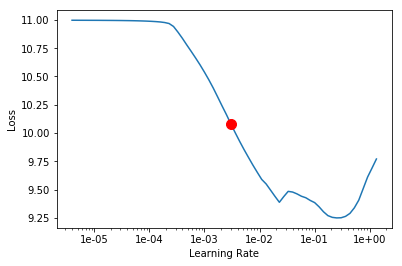

In [8]:
learn.lr_find()
learn.recorder.plot(skip_end=10, skip_start=20, suggestion=True)

In [12]:
learn.unfreeze()
learn.fit_one_cycle(10, lr, moms=(0.8,0.7), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='lm')])

/home/jdg/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every best is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,accuracy,time
0,4.343431,4.325415,0.310286,2:37:49
1,4.504363,4.492033,0.294615,2:38:05
2,4.591702,4.564445,0.287716,2:37:56
3,4.536796,4.547905,0.288528,2:37:43
4,4.521063,4.500783,0.293255,2:37:57
5,4.416158,4.420656,0.299685,2:37:45
6,4.344989,4.323297,0.307992,2:37:53
7,4.196101,4.198405,0.322229,2:37:48
8,4.064900,4.075106,0.337517,2:37:57
9,3.995485,4.005140,0.348630,2:37:55


Better model found at epoch 0 with accuracy value: 0.3102859556674957.
Better model found at epoch 7 with accuracy value: 0.3222292363643646.
Better model found at epoch 8 with accuracy value: 0.3375166654586792.
Better model found at epoch 9 with accuracy value: 0.3486296236515045.


In [13]:
learn.save_encoder('lm_enc_v2_head')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-05
Min loss divided by 10: 1.32E-05


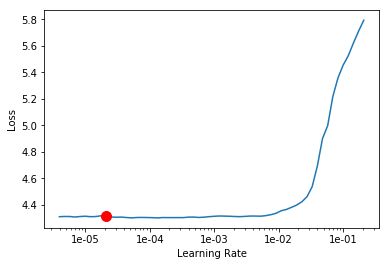

In [11]:
learn.lr_find()
learn.recorder.plot(skip_end=10, skip_start=20, suggestion=True)

In [14]:
learn.unfreeze()
learn.fit_one_cycle(3, 6e-4, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.167408,4.169284,0.325084,2:36:09
1,4.137351,4.087568,0.335562,2:36:14
2,4.023909,3.995072,0.349512,2:36:24


In [15]:
learn.save_encoder('lm_enc_v2')

In [18]:
learn.data.vocab.save('lm_enc_v2.pkl')

In [17]:
SPProcessor.load??

In [5]:
if not (PATH / 'data_clas_export.pkl').exists():
    df = pd.read_csv(PATH / 'train_prepro.csv')
    data_clas = (TextList.from_df(df, cols=['language', 'title'], processor = SPProcessor.load(''))
        .split_by_rand_pct(0.02, seed=42)
        .label_from_df(cols='category')
        .databunch(bs=64, num_workers=1))
    
    data_clas.save('data_clas_export.pkl')
else:
    data_clas = load_data(PATH, 'data_clas_export.pkl')

In [7]:
data_clas.show_batch(rows=10)

text,target
▁xxbos ▁spanish ▁cooler ▁para ▁hp ▁g 1 ▁1 d 1 ca ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 ca ▁g 1 ▁1 d 1 nr ▁g 1 ▁1 d 1 ca ▁g 1 ▁1 d 1 u ▁g 1 ▁1 d 1 ca ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 cl ▁g 1 ▁1 d 1 d x ▁g 1,DESKTOP_COMPUTER_COOLERS_AND_FANS
▁xxbos ▁spanish ▁transistor ▁igbt ▁hgt g 1 n 1 c 1 ▁g 1 n 1 c 1 ▁1 n 1 c 1 ▁1 v ▁1 a ▁ta ▁1,TRANSISTORS
▁xxbos ▁spanish ▁cooler ▁delta ▁ff b 1 sh n ▁1 x 1 x 1 mm ▁1 mm ▁1 ▁dc ▁1 v ▁1 ▁1 a,DESKTOP_COMPUTER_COOLERS_AND_FANS
▁xxbos ▁spanish ▁bateria ▁bt 1 b ▁1 ▁yt 1 b ▁b ▁ky m co 1 ▁qua n non ▁na ke ▁b ▁battery ▁ryd,MOTORCYCLE_BATTERIES
▁xxbos ▁portuguese ▁pacote ▁1 ▁chave ▁contator a ▁tripolar ▁1 a ▁lc 1 ▁d 1 m 1 ▁1 p ▁aux ▁nf ▁na ▁1 v,HOME_APPLIANCE_CONTACTORS_AND_RELAYS
▁xxbos ▁portuguese ▁chave ▁de ▁impacta ▁1 ▁1 mm ▁1 v ▁1 ah ▁1 v ▁max ▁dewalt ▁dcf 1 m 1 ▁com ▁maleta,IMPACT_WRENCHES
▁xxbos ▁spanish ▁bateria ▁de ▁ni ▁mh ▁1 ▁x ▁1 ▁1 v ▁h nn 1 a ▁para ▁motorola ▁gp 1 ▁lc s 1,CELLPHONE_BATTERIES
▁xxbos ▁spanish ▁memoria ▁kingston ▁ddr 1 ▁ecc ▁1 gb ▁kit ▁1 x ▁1 gb ▁kvr 1 e 1 k 1 ▁1,RAM_MEMORY_MODULES
▁xxbos ▁spanish ▁ventilador ▁cooler ▁fan ▁eb m ▁pa p st ▁1 vdc ▁1 x 1 x 1 mm ▁typ 1 ▁1,DESKTOP_COMPUTER_COOLERS_AND_FANS
▁xxbos ▁portuguese ▁cortina ▁suede ▁1 ▁1 m ▁x ▁1 ▁1 m ▁p ▁varaa ▁1 m ▁x ale ▁1 ▁1 m ▁franja,INDOOR_CURTAINS_AND_BLINDS


In [21]:
data_clas.train_ds.x[6]

Text xxbos diesel zera plu m decant amostra xxmaj xml original frete grati

In [8]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, bptt=16, path=PATH, pretrained=False, wd=0.1)
learn.load_encoder('lm_enc_v2')
learn.freeze()

In [10]:
lr=2e-2
lr *= 64/48

In [12]:
learn.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.911806,2.204494,0.527376,1:00:41
1,1.584605,1.157751,0.769114,59:31


In [13]:
learn.save('classifier_v2_0')

In [14]:

learn.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.896475,2.197062,0.530046,59:58
1,1.688922,1.158908,0.768067,1:01:46


In [15]:
learn.save('class_fit_head_v2')

In [16]:
learn.freeze_to(-2)

In [17]:
learn.fit_one_cycle(1, slice(3e-3/(2.6**4), 3e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.138601,0.866741,0.821265,1:10:49


In [6]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, bptt=16, path=PATH, pretrained=False, wd=0.1)
learn.load('class_fit_head_v2')
learn.freeze_to(-3)

In [7]:
learn.fit_one_cycle(1, slice(3e-3/(2.6**4), 3e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.979064,0.800780,0.839977,1:43:41


In [8]:
learn.save('class_fit_head_v2')

In [113]:
learn.unfreeze()

In [114]:
learn.fit_one_cycle(
    7, slice(3e-3/(2.6**4), 3e-3), moms=(0.8, 0.7), 
    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='class_fit_full_v2')]
)

epoch,train_loss,valid_loss,accuracy,time
0,0.823603,0.660990,0.855746,1:21:06
1,0.806030,0.629765,0.861902,1:21:58
2,0.741846,0.603677,0.867034,1:02:37
3,0.704139,0.584585,0.871320,1:14:34
4,0.688411,0.566787,0.874653,1:24:44
5,0.644176,0.550823,0.877210,1:25:56
6,0.633675,0.548044,0.878074,1:23:38


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 2.51E-04


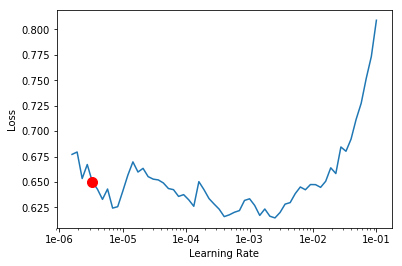

In [75]:
learn.lr_find()
learn.recorder.plot(skip_end=10, skip_start=15, suggestion=True)

In [116]:
learn.fit_one_cycle(1, 1e-4/2)

epoch,train_loss,valid_loss,accuracy,time
0,0.683283,0.547660,0.878459,1:19:43


In [117]:
learn.save('class_fit_top3')

In [118]:
learn.fit_one_cycle(1, 1e-2/3)

epoch,train_loss,valid_loss,accuracy,time
0,0.649676,0.565369,0.875279,1:23:05


In [9]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, bptt=16, path=PATH, pretrained=False, wd=0.1)
learn.load('class_fit_head_v2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (19599954 items)
x: TextList
▁xxbos ▁spanish ▁hidrolavadora ▁lavor ▁one ▁1 ▁bar ▁1 w ▁bomba ▁aluminia ▁italia,▁xxbos ▁spanish ▁placa ▁de ▁sonida ▁behringer ▁umc 1,▁xxbos ▁portuguese ▁maquina ▁de ▁lavar ▁electrolux ▁1 ▁kila,▁xxbos ▁portuguese ▁par ▁disca ▁de ▁freia ▁diant ▁vent ▁gol ▁1 v ▁1 ▁fremax ▁bd 1,▁xxbos ▁spanish ▁flash e ▁led ▁pestana ▁luminosa ▁falsa ▁pestana ▁para ▁partida
y: CategoryList
ELECTRIC_PRESSURE_WASHERS,SOUND_CARDS,WASHING_MACHINES,VEHICLE_BRAKE_DISCS,FALSE_EYELASHES
Path: .;

Valid: LabelList (399999 items)
x: TextList
▁xxbos ▁portuguese ▁roupa ▁termica ▁forra ▁peluciada ▁segunda ▁pele ▁viagem ▁e ▁pijama,▁xxbos ▁portuguese ▁cafeteira ▁eletrica ▁d cm 1 z ▁makita ▁1 v ▁original ▁bateria,▁xxbos ▁portuguese ▁correia ▁panificadora ▁p rita nia ▁multipane ▁polia ▁arruela,▁xxbos ▁portuguese ▁colchaa ▁d 1 ▁solteira ▁americana ▁medida ▁especial ▁pra ▁confort,▁xxbos ▁portuguese ▁baba ▁eletronica ▁motorola ▁mbp 1 ▁connect ▁w

In [11]:
learn.show_results()

text,target,prediction
▁xxbos ▁spanish ▁cooler ▁para ▁hp ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 ca ▁g 1 ▁1 d 1 ca ▁g 1 ▁1 d 1 d x ▁g 1 ▁1 d 1 ca ▁g 1 ▁1 d 1,DESKTOP_COMPUTER_COOLERS_AND_FANS,DESKTOP_COMPUTER_COOLERS_AND_FANS
▁xxbos ▁spanish ▁cooler ▁para ▁hp ▁g 1 ▁1 a 1 u ▁g 1 ▁1 a 1 u ▁g 1 ▁1 a 1 nr ▁g 1 ▁1 a 1 nr ▁g 1 ▁1 a 1 w m ▁g 1 ▁1 a 1 nr ▁g 1 ▁1 a 1 nr ▁g 1 ▁1 a 1 u ▁g 1 ▁1 a 1 nr ▁g 1 ▁1 a 1 d x ▁g 1 ▁1,DESKTOP_COMPUTER_COOLERS_AND_FANS,DESKTOP_COMPUTER_COOLERS_AND_FANS
▁xxbos ▁spanish ▁bateria ▁aa ▁p bz n 1 tp ▁para ▁samsung ▁chromebook ▁1 ▁ativ ▁x e 1 t 1 c ▁1 c ▁x e 1 c 1 ▁x e 1 c ▁x e 1 t ▁x e 1 c ▁x e 1 c ▁x e 1 c 1 ▁x e 1 c 1 ▁a,LAPTOP_BATTERIES,LAPTOP_BATTERIES
▁xxbos ▁spanish ▁bateria ▁a 1 ▁u 1 ▁para ▁asu ▁u 1 ▁u 1 a ▁q 1 ▁q 1 a ▁q 1 c ▁r 1 ▁u 1 c ▁u 1 v ▁u 1 v c ▁serie ▁a 1 ▁u 1 ▁a 1 ▁u 1 ▁a 1 ▁u 1 ▁1 v ▁1 mah ▁1,LAPTOP_BATTERIES,LAPTOP_BATTERIES
▁xxbos ▁portuguese ▁controle ▁akb 1 ▁lm nc 1 l ra 1 ▁amb bla t ▁lm nc 1 lt a 1 ▁amba la t ▁ts nh 1 lb a 1 ▁amba la z ▁lt nh 1 q le 1 ▁an w bla t ▁sh n 1 q a ▁am bba m z,AIR_CONDITIONER_REMOTE_CONTROLS,AIR_CONDITIONER_REMOTE_CONTROLS


In [38]:
test = pd.read_csv(PATH / 'test.csv')

In [39]:
test['title'] = test.language + ' ' + test.title.apply(normalize_title)
test.pop('id');
test.pop('language');

In [40]:
test.head()

,title
0,portuguese kit maternidade bolsa mala baby beb...
1,portuguese trocador de fralda fisher price fem...
2,portuguese motor ventoinha fiat idea palia 1 a...
3,portuguese amortecedor mola batente d dir new ...
4,portuguese cadeirinha de carra bebe princesa p...


In [41]:
learn.data.add_test(test, label=None)

In [42]:
learn.data.show_batch(ds_type=DatasetType.Test, rows=10)

text,target
▁xxbos ▁portuguese ▁kit ▁maternidade ▁bolsa ▁mala ▁baby ▁bebe ▁vinha ▁menina ▁kb 1,3D_GLASSES
▁xxbos ▁portuguese ▁trocador ▁de ▁fralda ▁fisher ▁price ▁feminina ▁rosa ▁portatil,3D_GLASSES
▁xxbos ▁portuguese ▁motor ▁ventoinha ▁fiat ▁idea ▁palia ▁1 ▁a ▁1 ▁k,3D_GLASSES
▁xxbos ▁portuguese ▁amortecedor ▁mola ▁batente ▁d ▁dir ▁new ▁civic ▁1 ▁k,3D_GLASSES
▁xxbos ▁portuguese ▁cadeirinha ▁de ▁carra ▁bebe ▁princesa ▁princes ▁1 ▁a ▁1 ▁kg,3D_GLASSES
▁xxbos ▁portuguese ▁caba ▁freia ▁maa ▁tra ▁direita ▁vw ▁up ▁cod ▁1 s 1 e ▁1 ▁j,3D_GLASSES
▁xxbos ▁portuguese ▁mini ▁pc ▁dell ▁optiplex ▁fx 1 ▁atom ▁1 gb ▁ram ▁ssd ▁1 gb ▁wifi,3D_GLASSES
▁xxbos ▁portuguese ▁kit ▁bi ▁xenon ▁lampada ▁h 1 ▁1 k,3D_GLASSES
▁xxbos ▁portuguese ▁protetor ▁pe ▁botinha ▁kickboxing ▁karate ▁taekwonda ▁competicaa,3D_GLASSES
▁xxbos ▁spanish ▁disca ▁rigida ▁externa ▁western ▁digital ▁element ▁1 tb ▁usb 1 ▁1,3D_GLASSES


In [44]:
print(learn.data.train_ds.x[0])
print(learn.data.valid_ds.x[0])
print(learn.data.test_ds.x[0])

▁xxbos ▁spanish ▁hidrolavadora ▁lavor ▁one ▁1 ▁bar ▁1 w ▁bomba ▁aluminia ▁italia
▁xxbos ▁portuguese ▁roupa ▁termica ▁forra ▁peluciada ▁segunda ▁pele ▁viagem ▁e ▁pijama
▁xxbos ▁portuguese ▁kit ▁maternidade ▁bolsa ▁mala ▁baby ▁bebe ▁vinha ▁menina ▁kb 1


246955

In [45]:
probs = learn.get_preds(ds_type=DatasetType.Test)
pred_indices = torch.argmax(probs[0], dim=1)
preds_clas = [data_clas.classes[pred] for pred in pred_indices]

In [46]:
for x in range(10, 20):
    print(learn.data.test_ds[x], preds_clas[x])

(Text ▁xxbos ▁spanish ▁picadora ▁de ▁carne ▁fineschi ▁legitima ▁1, EmptyLabel ) MEAT_GRINDERS
(Text ▁xxbos ▁portuguese ▁saida ▁maternidade ▁1 ▁manta ▁1 vestida ▁1 cal ca ▁brinde ▁ref ▁1, EmptyLabel ) BABY_CLOTHING_SETS
(Text ▁xxbos ▁portuguese ▁joga ▁vela ▁ignicaa ▁ngk ▁mercede ▁benz ▁1 ▁clc ▁1 ▁kompressor, EmptyLabel ) SPARK_PLUGS
(Text ▁xxbos ▁portuguese ▁modula ▁de ▁injecaa ▁fox ▁flex ▁1 ▁aa, EmptyLabel ) ENGINE_CONTROL_MODULES
(Text ▁xxbos ▁spanish ▁set ▁barreta ▁automotor ▁bremen ▁x 1 ▁unid ▁1 ▁1 cm, EmptyLabel ) CHISELS
(Text ▁xxbos ▁spanish ▁miel ▁organica ▁x 1 gr ▁sin ▁tacc, EmptyLabel ) HONEY
(Text ▁xxbos ▁portuguese ▁sax ▁tenor ▁coon ▁1 m, EmptyLabel ) SAXOPHONES
(Text ▁xxbos ▁portuguese ▁sapata ▁seguranca ▁vaqueta ▁bidensidade ▁com ▁biqueira ▁de ▁pvc, EmptyLabel ) SAFETY_FOOTWEAR
(Text ▁xxbos ▁portuguese ▁1 ▁adaptador ▁para ▁cartaa ▁de ▁memoria ▁micra ▁sd ▁frete ▁grati, EmptyLabel ) MEMORY_CARD_READERS
(Text ▁xxbos ▁spanish ▁bandeja ▁giradisca ▁omni tronic ▁bd 1, EmptyLabel 

In [47]:
test = pd.read_csv(PATH / 'test.csv')
test.pop('language');
test.pop('title');
test['category'] = preds_clas

In [48]:
test.to_csv('submission.csv', index=False)